# 6.6 Sourcing & Analyzing Time-Series Data

### This script contains the following:

#### 1. Importing your libraries and data

#### 2. Subsetting, wrangling, and cleaning time-series data

#### 3. Time series analysis: decomposition¶

#### 4. Testing for stationarity

#### 5. Stationarizing the Federal Reserve Economic Data









### 1. Importing dataset

In [27]:

import quandl
from dateutil.parser import parse 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm # Using .api imports the public access version of statsmodels, which is a library that handles 
# statistical models.
import os
import warnings # This is a library that handles warnings.

warnings.filterwarnings("ignore") # Disable deprecation warnings that could indicate, for instance, a suspended library or 
# feature. These are more relevant to developers and very seldom to analysts.

plt.style.use('fivethirtyeight') # This is a styling option for how your plots will appear. More examples here:
# https://matplotlib.org/3.2.1/tutorials/introductory/customizing.html
# https://matplotlib.org/3.1.0/gallery/style_sheets/fivethirtyeight.html

In [28]:
# Define the path to the data files
path = r'/Users/milivanili/Desktop/CF Document 6'

In [29]:
# Import the df_death_pop_income.csv data

data = pd.read_csv(os.path.join(path,'01 Data','Prepared Data','df_cause_income.csv'))

### 2. Subsetting , wrangling and cleaning dataset

In [30]:
# Filter the data for Canada and the United States of America
data2 = data[data['Country'].isin(['Canada', 'United States of America'])]


In [31]:
# Select relevant columns
data2 = data2[['Country', 'Year', 'Alcohol use', 'Population']]

In [32]:
# Calculate per capita alcohol use
data2['Alcohol use per capita'] = data2['Alcohol use'] / data2['Population']

In [33]:
# Convert 'Year' to datetime and set as index
data2['Year'] = pd.to_datetime(data2['Year'], format='%Y')
data2.set_index('Year', inplace=True)


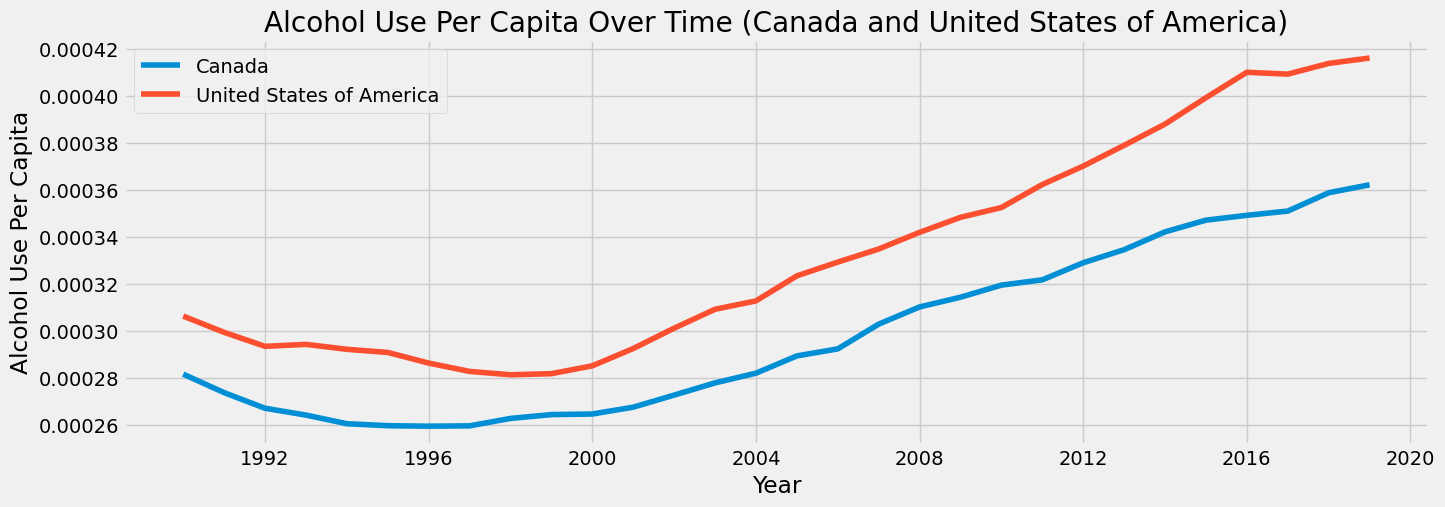

In [34]:
# Visualize the filtered data
plt.figure(figsize=(15, 5), dpi=100)
for country in data2['Country'].unique():
    country_data = data2[data2['Country'] == country]['Alcohol use per capita']
    plt.plot(country_data, label=country)

plt.xlabel('Year')
plt.ylabel('Alcohol Use Per Capita')
plt.title('Alcohol Use Per Capita Over Time (Canada and United States of America)')
plt.legend()
plt.grid(True)
plt.show()

### 3. Time-series analysis: decomposition

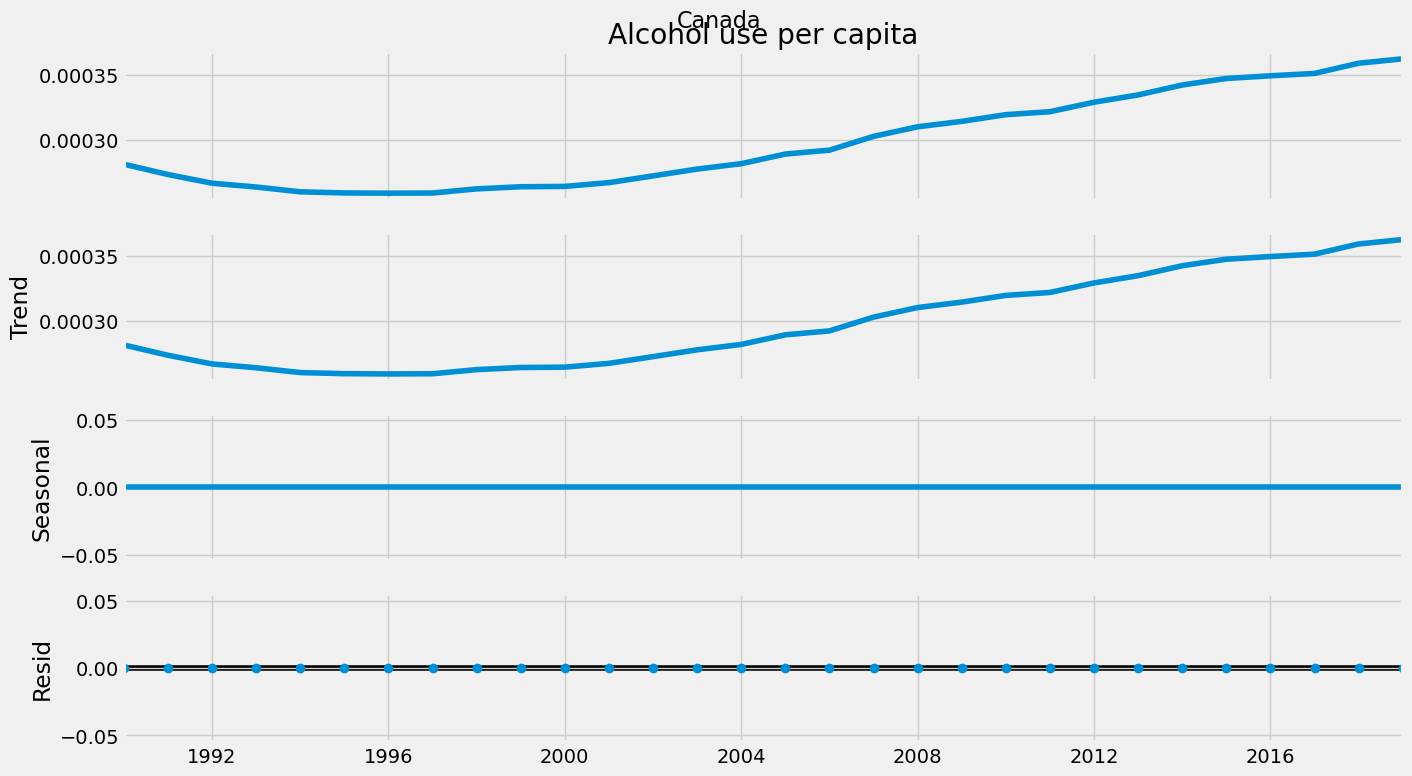

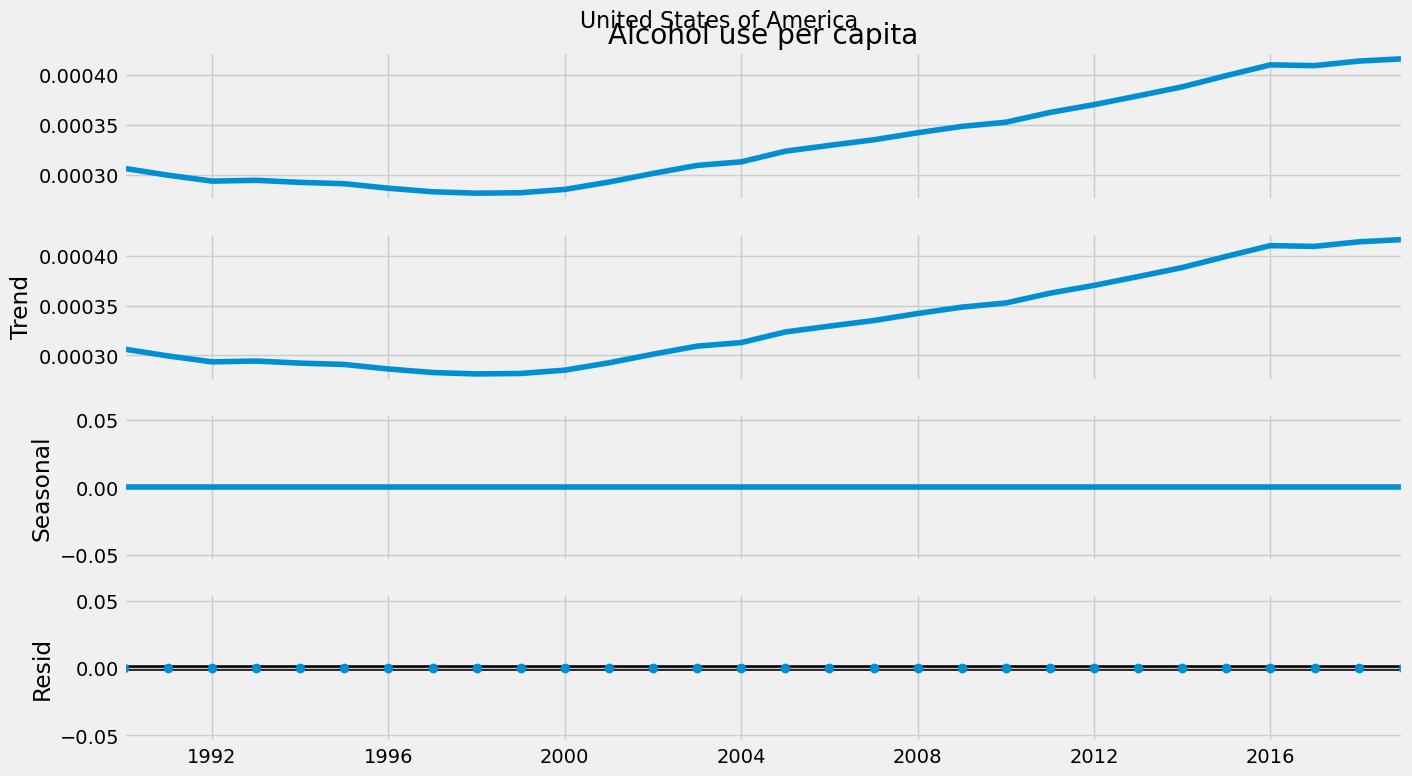

In [39]:
# Decompose the time series for each country
decompositions = {}
for country in data2['Country'].unique():
    country_data = data2[data2['Country'] == country]['Alcohol use per capita']
    decompositions[country] = sm.tsa.seasonal_decompose(country_data, model='additive')

# Plot the decomposed components for each country
for country, decomposition in decompositions.items():
    fig = decomposition.plot()
    fig.suptitle(country, fontsize=16)
    fig.set_size_inches(14, 8)
    plt.show()


#### Observation: 
Both countries exhibit a clear upward trend in alcohol use per capita over the years, with the United States showing a more pronounced increase.
Seasonal patterns are evident in both countries, indicating regular annual fluctuations in alcohol use.
The residual components suggest that while the trend and seasonality capture much of the variation, there are still random fluctuations present, with the United States having slightly more irregularities compared to Canada.


### 4. Testing for stationarity 

In [43]:
# The adfuller() function will import from the model from statsmodels for the test; however, running it will only return an array of numbers. This is why you need to also define a function that prints the correct output from that array.\n",

from statsmodels.tsa.stattools import adfuller 
    

# Define Dickey-Fuller test function
def dickey_fuller(timeseries):
    print('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic', 'p-value', 'Number of Lags Used', 'Number of Observations Used'])
    for key, value in test[4].items():
        result['Critical Value (%s)' % key] = value
    print(result)

# Apply the Dickey-Fuller test on the original data
for country in data2['Country'].unique():
    print(f"\nStationarity Test for {country}:")
    country_data = data2[data2['Country'] == country]['Alcohol use per capita']
    dickey_fuller(country_data)



Stationarity Test for Canada:
Dickey-Fuller Stationarity test:
Test Statistic                  2.445320
p-value                         0.999030
Number of Lags Used             0.000000
Number of Observations Used    29.000000
Critical Value (1%)            -3.679060
Critical Value (5%)            -2.967882
Critical Value (10%)           -2.623158
dtype: float64

Stationarity Test for United States of America:
Dickey-Fuller Stationarity test:
Test Statistic                  2.435189
p-value                         0.999026
Number of Lags Used             0.000000
Number of Observations Used    29.000000
Critical Value (1%)            -3.679060
Critical Value (5%)            -2.967882
Critical Value (10%)           -2.623158
dtype: float64


#### Observations: The Dickey-Fuller test that we condacted shows that this time series are non - stationari.
Canada
The Critical Value (10%) is -2.967882, which is biger than the Statistic Test of 2.445320
Aslo the p - value of 0.9999030, indicated that the test result is not significan.

United States of America
The Critical Value (10%) is -2.967882, which is biger than the Statistic Test of 2.435189
Aslo the p - value of 0.9999030, indicated that the test result is not significan.


In [45]:
data2.head()

,Country,Alcohol use,Population,Alcohol use per capita
Year,,,,
1990-01-01,Canada,7800,27691138.0,0.000282
1991-01-01,Canada,7677,28037420.0,0.000274
1992-01-01,Canada,7580,28371264.0,0.000267
1993-01-01,Canada,7580,28684764.0,0.000264
1994-01-01,Canada,7557,29000663.0,0.000261


<Figure size 1200x600 with 0 Axes>

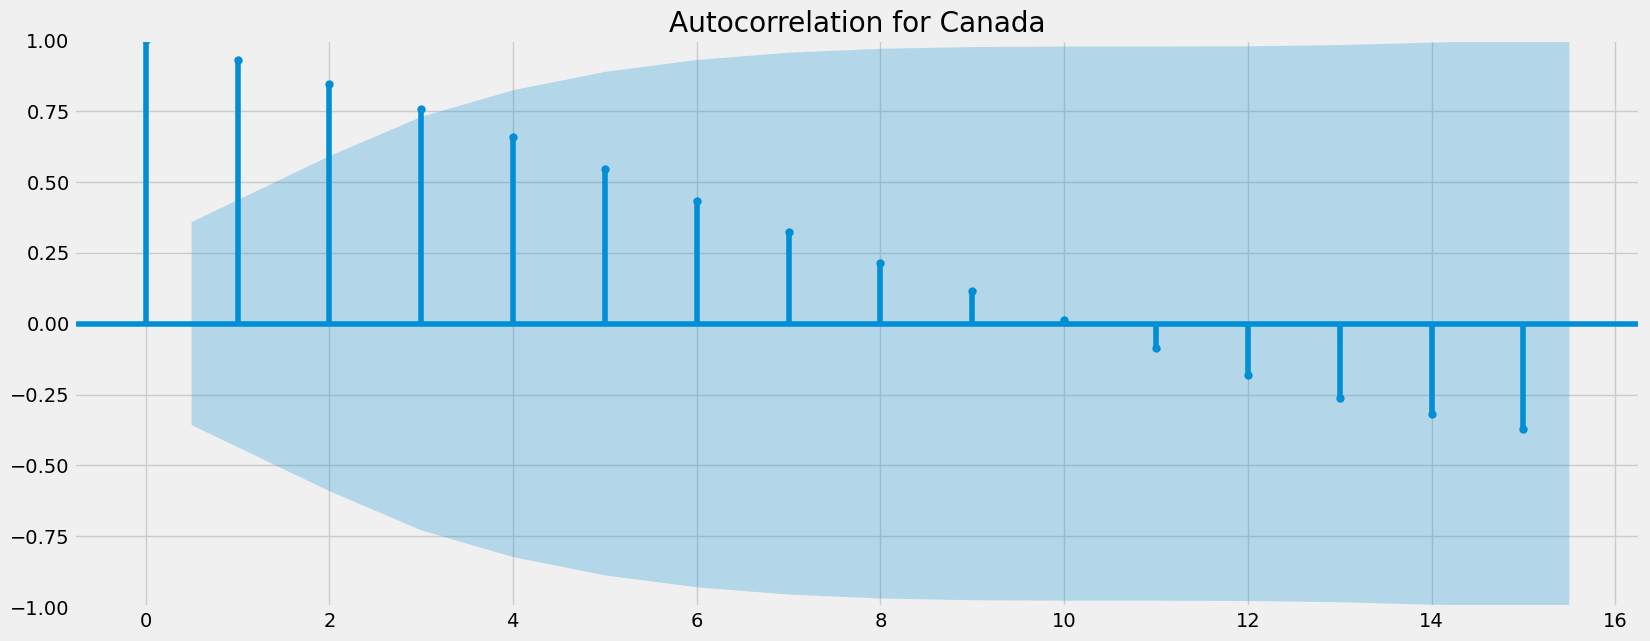

<Figure size 1200x600 with 0 Axes>

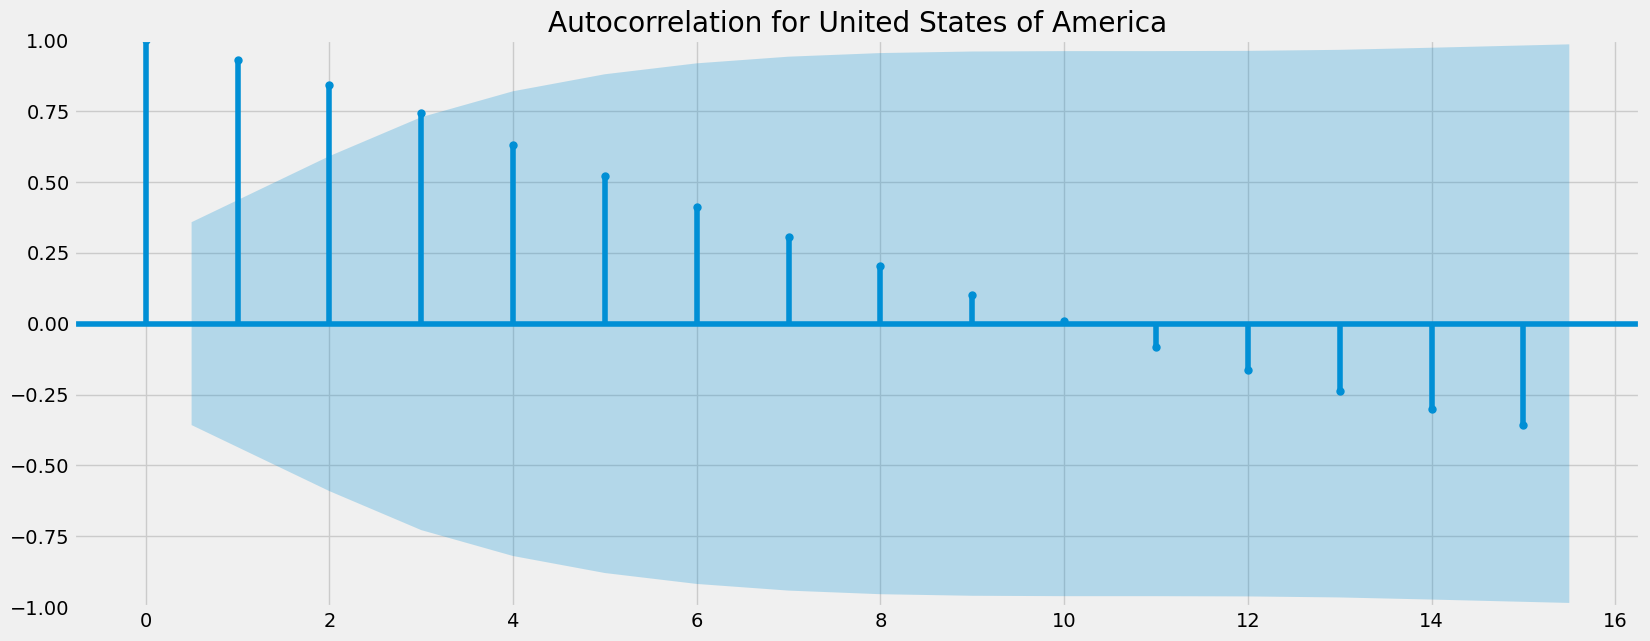

In [46]:
# Plot the autocorrelation for each country
for country in data2['Country'].unique():
    plt.figure(figsize=(12, 6))
    country_data = data2[data2['Country'] == country]['Alcohol use per capita']
    plot_acf(country_data, title=f'Autocorrelation for {country}')
    plt.show()


#### The significant positive autocorrelations for the first few lags in both countries suggest a strong trend component in the time series data.
#### The diminishing autocorrelations with increasing lags indicate that the influence of past values decreases over time.

### 5: Differencing the Data to Make it Stationary

In [47]:
# Difference the data to make it stationary
df_diff = data2.groupby('Country')['Alcohol use per capita'].diff().dropna().reset_index()

In [48]:
df_diff.head()

,Year,Alcohol use per capita
0,1991-01-01,-7.865924e-06
1,1992-01-01,-6.640899e-06
2,1993-01-01,-2.919959e-06
3,1994-01-01,-3.671532e-06
4,1995-01-01,-8.396441e-07


In [49]:
df_diff.columns

Index(['Year', 'Alcohol use per capita'], dtype='object')

#### Stationarity Test on Differenced Data

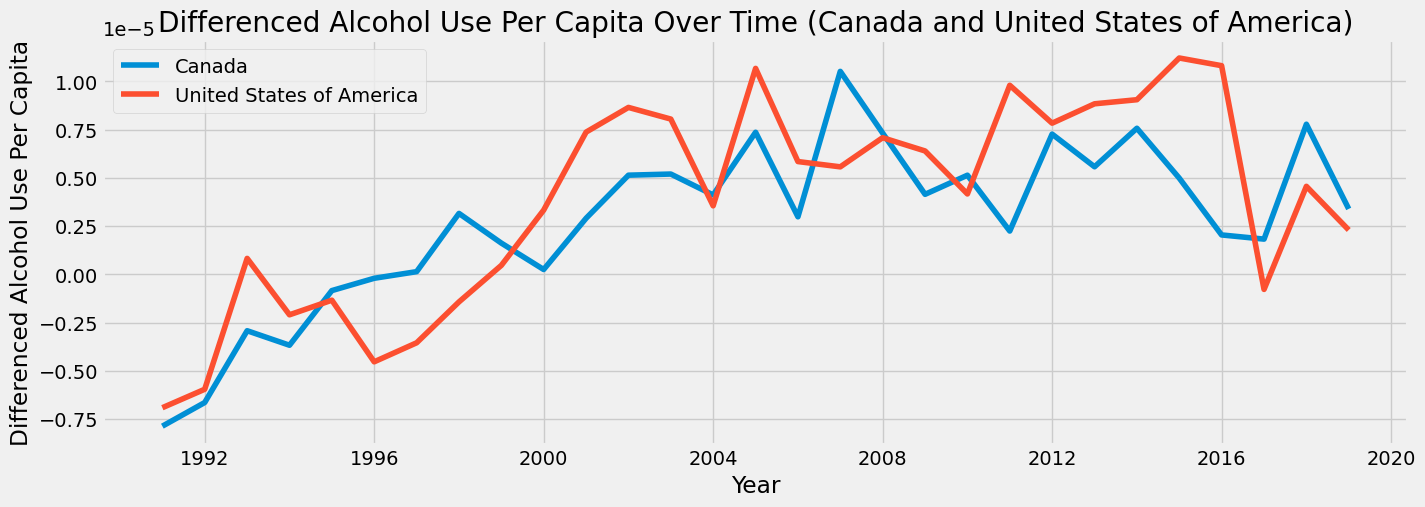

In [50]:
# Plot the differenced data
plt.figure(figsize=(15, 5), dpi=100)
for country in data2['Country'].unique():
    country_data = data2[data2['Country'] == country]['Alcohol use per capita'].diff().dropna()
    plt.plot(country_data, label=country)

plt.xlabel('Year')
plt.ylabel('Differenced Alcohol Use Per Capita')
plt.title('Differenced Alcohol Use Per Capita Over Time (Canada and United States of America)')
plt.legend()
plt.grid(True)
plt.show()

In [51]:
# Apply the Dickey-Fuller test on the differenced data
for country in data2['Country'].unique():
    print(f"\nStationarity Test for {country} (Differenced Data):")
    country_data = data2[data2['Country'] == country]['Alcohol use per capita'].diff().dropna()
    dickey_fuller(country_data)



Stationarity Test for Canada (Differenced Data):
Dickey-Fuller Stationarity test:
Test Statistic                 -3.067322
p-value                         0.029068
Number of Lags Used             0.000000
Number of Observations Used    28.000000
Critical Value (1%)            -3.688926
Critical Value (5%)            -2.971989
Critical Value (10%)           -2.625296
dtype: float64

Stationarity Test for United States of America (Differenced Data):
Dickey-Fuller Stationarity test:
Test Statistic                 -2.639317
p-value                         0.085140
Number of Lags Used             0.000000
Number of Observations Used    28.000000
Critical Value (1%)            -3.688926
Critical Value (5%)            -2.971989
Critical Value (10%)           -2.625296
dtype: float64



##### Dickey-Fuller Test After Differencing:
Canada

Test Statistic: -3.067322

p-value: 0.029068


##### The test statistic is less than the critical values at the 5% and 10% significance levels.
The p-value is below 0.05.
Observation:
We can reject the null hypothesis for Canada after differencing, indicating that the series has become stationary.


##### Dickey-Fuller Test After Differencing:
United States of America

Test Statistic: -2.639317

p-value: 0.085140

##### The test statistic is greater than the critical values at the 1% and 5% significance levels but slightly less than the 10% level.
The p-value is above 0.05.
Observation:

We cannot reject the null hypothesis for the United States of America after differencing, indicating that the series is still not fully stationary and may require further differencing or other transformations.

#### Plot Autocorrelations for Differenced Data

<Figure size 1200x600 with 0 Axes>

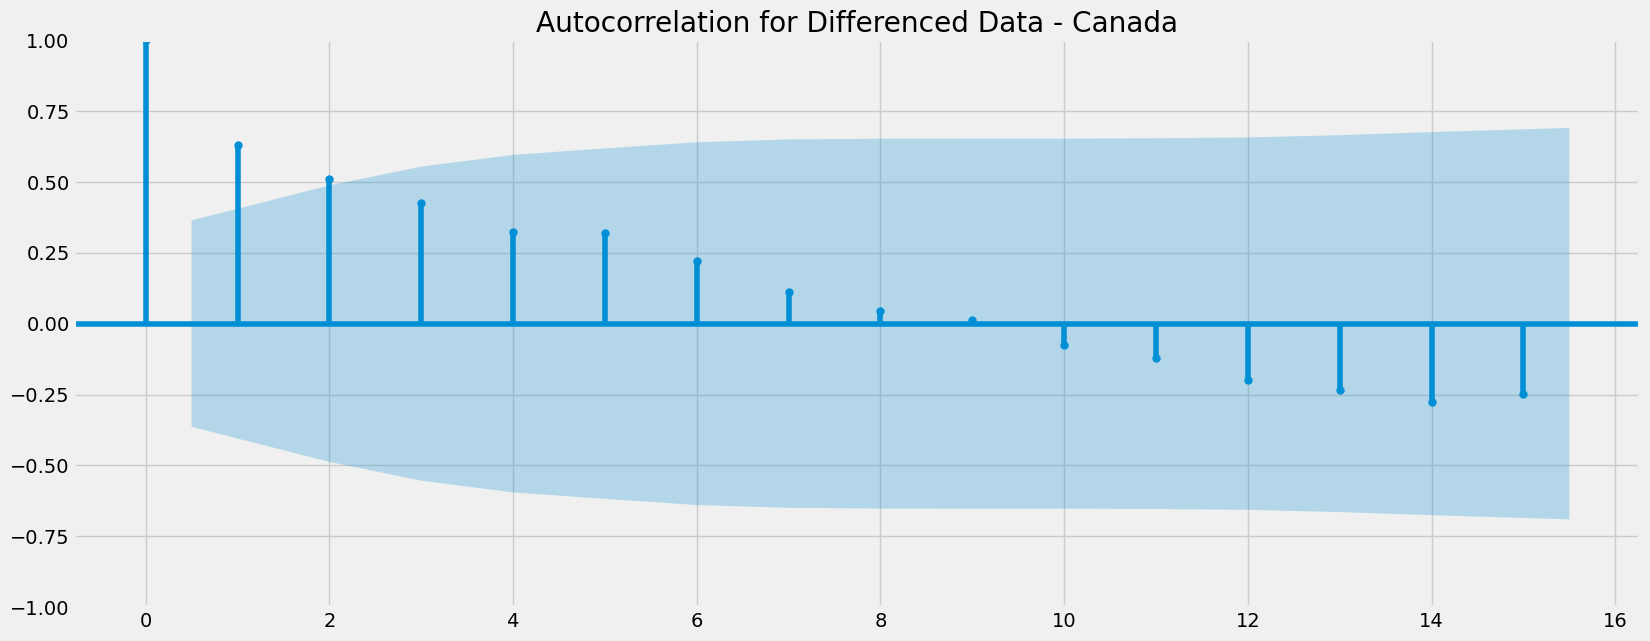

<Figure size 1200x600 with 0 Axes>

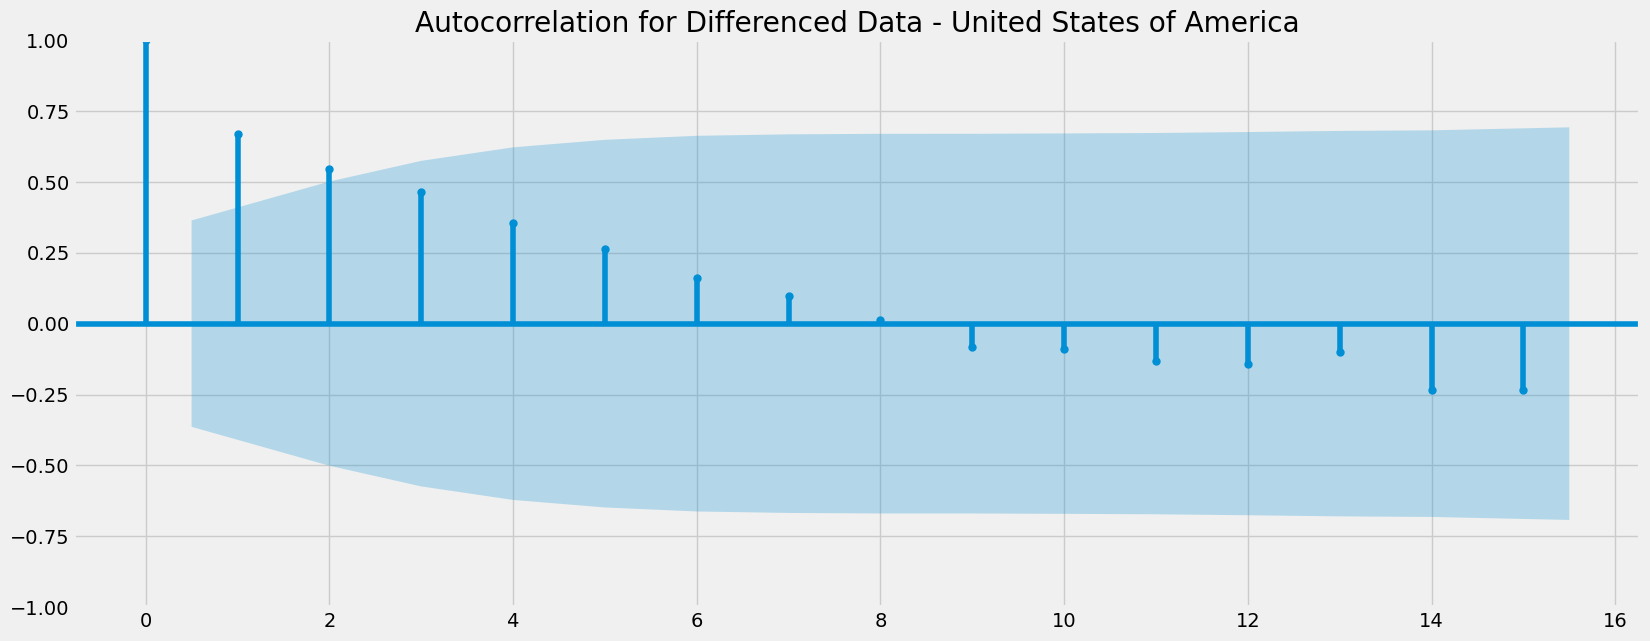

In [54]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot the autocorrelation for the differenced data for each country
for country in data2['Country'].unique():
    plt.figure(figsize=(12, 6))
    country_data = data2[data2['Country'] == country]['Alcohol use per capita'].diff().dropna()
    plot_acf(country_data, title=f'Autocorrelation for Differenced Data - {country}')
    plt.show()


#### The time series for Canada becomes strongly stationary after differencing, while the series for the United States of America shows weak stationarity and may require further differencing or transformations to achieve full stationarity.





